<a href="https://colab.research.google.com/github/akan72/comp590/blob/master/notebooks/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive

drive.mount('/content/drive/')
!ls '/content/drive/My Drive/Geospatial Analytics/'  

!curl -s https://course.fast.ai/setup/colab | bash

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
'Week 10 (03-30)'			'Week 2 (01-27)'  'Week 7 (03-02)'
'Week 11 (04-06)'			'Week 3 (02-03)'  'Week 8 (03-16)'
'Week 12 (04-13)'			'Week 4 (02-10)'  'Week 9 (03-23)'
'Week 13 (04-20)'			'Week 5 (02-17)'
'Week 14 - Final Presentation (04-30)'	'Week 6 (02-24)'
Updating fastai...
Done.


In [0]:
import ee 
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/wAHafIl8__NBgv1dEs8dKvSdSs15xBkafPWKfG6XBu8qQsBcp4Sh8n4

Successfully saved authorization token.


IMAGE VISUALIZATION

Planet Dataset 

https://developers.google.com/earth-engine/datasets/catalog/SKYSAT_GEN-A_PUBLIC_ORTHO_RGB

Object-Based Methods

https://developers.google.com/earth-engine/image_objects#label_objects

Convolutions and Object-based Image Segmentation 

https://developers.google.com/earth-engine/image_convolutions
https://gis.stackexchange.com/questions/273658/performing-object-based-image-classification-in-google-earth-engine

Edge Detection

https://developers.google.com/earth-engine/image_edges

In [0]:
# https://developers.google.com/earth-engine/python_install-colab.html
import folium
import matplotlib.pyplot as plt
from IPython.display import Image

# Folium Utilities 
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

def coordinateBox(lon: float, lat: float, lon_step: float, lat_step: float):
  return [[[lon-lon_step, lat+lat_step], [lon-lon_step, lat-lat_step],
           [lon+lon_step, lat-lat_step], [lon+lon_step, lat+lat_step]]]

sfLon = -122.431297
sfLat = 37.773972

In [122]:
# https://developers.google.com/earth-engine/tutorial_api_04

# Sentinel-2
# https://developers.google.com/earth-engine/datasets/catalog/sentinel-2

# Planet SkySat Public Ortho Imagery, RGB (higher res)
# https://developers.google.com/earth-engine/datasets/catalog/SKYSAT_GEN-A_PUBLIC_ORTHO_RGB
# data = ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB')

# Higher resolution necessary?
# USGS Landsat 8 Collection 1 Tier 1 TOA Reflectance, RGB
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA
data = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')

features = ee.FeatureCollection(ee.FeatureCollection(ee.Geometry.Point([sfLon, sfLat])))
spatialFilter = data.filterBounds(features)
temporalFilter = spatialFilter.filterDate('2019-01-01', '2019-12-31')

# Display San Francisco's least cloudy day of 2019.
data = temporalFilter.sort('CLOUD_COVER').first()

mask = data.updateMask(data.gt(0))
mask_params = {
    'bands': ['B4', 'B3', 'B2'],
    'max': .3,
}

kernel = ee.Kernel.laplacian8(
    normalize=False
)

edge = mask.convolve(kernel)
edge_params = {
    'bands': ['B5', 'B4', 'B3'],
    'max': .5,
    'format': 'png'
}

elevation = ee.Image('USGS/SRTMGL1_003')
elevation_params = {
  'min': 0,
  'max': 4000,
  'dimensions': 512,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}
elevation_mask = elevation.updateMask(elevation.gt(0))

# # Add the elevation model to the map object.
# my_map.add_ee_layer(dem.updateMask(dem.gt(0)), dem_vis_params, 'DEM')
my_map = folium.Map(
    location=[sfLat, sfLon],
    zoom_start=12,
)

my_map.add_ee_layer(elevation, elevation_params, 'ELEVATION')
my_map.add_ee_layer(edge, edge_params, 'EDGE')
my_map.add_ee_layer(mask, mask_params, 'RGB')
my_map.add_child(folium.LayerControl())

In [124]:
# Plotting a static image
Image(url=elevation_mask
  .getThumbUrl({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

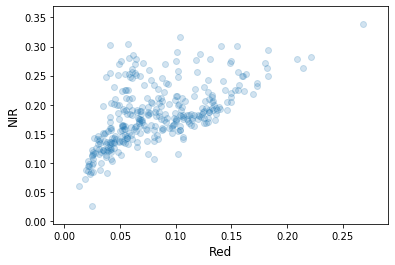

In [0]:
# Matplotlib plotting example
# https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=JGnotb1n73Yk

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()